In [1]:
from csv import DictReader
from random import Random
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

In [2]:
RANDOM = Random(42)

## Load Data

In [3]:
def load_samples(path):
    with open(path) as f:
        samples = list(DictReader(f))
        for sample in samples:
            sample['target'] = int(sample.get('target', -1))
        return samples

In [4]:
def train_val_split(samples, split=0.2):
    RANDOM.shuffle(samples)
    n_val = int(len(samples) * split)
    return samples[:-n_val], samples[-n_val:]

In [5]:
def undersample_majority(samples, factor=2.0):
    classes, counts = np.unique([sample['target'] for sample in samples], return_counts=True)
    minority_class_count = counts.min()
    undersampled = []
    for class_ in classes:
        class_samples = [sample for sample in samples if sample['target'] == class_]
        RANDOM.shuffle(class_samples)
        undersampled.extend(class_samples[:int(minority_class_count * factor)])
    return undersampled

In [6]:
samples = load_samples('/Users/suhancho/data/kaggle/quora_insincere/train.csv')

In [7]:
import pandas as pd
rawdata = pd.read_table('/Users/suhancho/data/kaggle/quora_insincere/train.csv',sep=',')

In [9]:
train_samples, val_samples = train_val_split(samples)

## Sampling

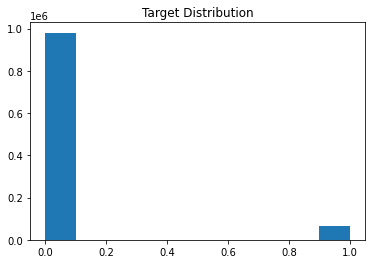

In [10]:
plt.title('Target Distribution')
plt.hist([sample['target'] for sample in train_samples])
plt.show()

## Preprocessing

In [11]:
def build_vocabulary(samples, vocab_min_freq=100):
    counts = Counter(ch for sample in samples for ch in sample['question_text'])
    chars = sorted(ch for ch, count in counts.items() if count >= vocab_min_freq)
    return {char: i for i, char in enumerate(chars)}

In [12]:
vocabulary = build_vocabulary(train_samples)
# print(len(vocabulary))
# vocabulary

In [13]:
def transform(sample, vocabulary):
    sample['encoded_text'] = [vocabulary[ch] for ch in sample['question_text'] if ch in vocabulary]
    return sample

In [12]:
train_samples = [transform(sample, vocabulary) for sample in train_samples]
val_samples = [transform(sample, vocabulary) for sample in val_samples]

## Modeling

In [14]:
import keras
from keras import backend as K
from keras import initializers, regularizers, constraints
# from keras.engine import Layer
# from tensorflow.keras.layers import Layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
# from keras.layers import InputLayer, Input

class AttentionWithContext(keras.layers.Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.

    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.

    Note: The layer has been tested with Keras 2.0.6

    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape = (input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [15]:
from keras import models, Model
from keras.layers import Input, Embedding, Conv1D, Add, Dense, SpatialDropout1D

def _conv_block(x, filters, kernel_size):
    conv = Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
    conv = Conv1D(filters, kernel_size, activation='relu', padding='same')(conv)
    return conv


def _resblock(x, filters, kernel_size):
    conv = _conv_block(x, filters, kernel_size)
    projection = Conv1D(filters, 1, padding='same')(x)
    return Add()([conv, projection])


def troll_hunter(vocab_size,
                 char_embedding_size,
                 base_filters,
                 doc_embedding_size,
                 dropout):
    text = Input(shape=(None,))
    embedding = Embedding(vocab_size, char_embedding_size)(text)

    conv_1 = _resblock(embedding, base_filters, 3)
    conv_1 = SpatialDropout1D(dropout)(conv_1)
    conv_2 = _resblock(conv_1, base_filters * 2, 3)
    conv_2 = SpatialDropout1D(dropout)(conv_2)
    conv_3 = _resblock(conv_2, base_filters * 4, 3)
    conv_3 = SpatialDropout1D(dropout)(conv_3)
    conv_4 = _resblock(conv_3, base_filters * 8, 3)
    conv_4 = SpatialDropout1D(dropout)(conv_4)

    attention = AttentionWithContext()(conv_4)

    fc_1 = Dense(doc_embedding_size, activation='relu')(attention)
    fc_2 = Dense(doc_embedding_size, activation='relu')(fc_1)
    prediction = Dense(1, activation='sigmoid')(fc_2)

    model = Model(text, prediction)
    model.compile('adam', 'binary_crossentropy', metrics=['acc'])
    return model

## Training Support

In [16]:
from math import ceil

class BatchProvider:
    def __init__(self, samples, batch_size, shuffle=False, run_forever=False):
        self._samples = samples
        self._batch_size = batch_size
        self._shuffle = shuffle
        self._run_forever = run_forever

    def generate_batches(self):
        batch = []
        indices = list(range(len(self._samples)))
        while True:
            if self._shuffle:
                RANDOM.shuffle(indices)
            for i in indices:
                batch.append(self.get_item(i))
                if len(batch) == self._batch_size:
                    yield self.transform_batch(batch)
                    batch = []
            if not self._run_forever:
                break
        if batch:
            yield self.transform_batch(batch)

    def __len__(self):
        return int(ceil(len(self._samples) / self._batch_size))

    def get_item(self, idx):
        sample = self._samples[idx]
        return sample['encoded_text'], sample['target']

    def transform_batch(self, items):
        texts, targets = zip(*items)
        max_length = max(len(text) for text in texts)
        text_batch = np.zeros((len(texts), max_length))
        for i, text in enumerate(texts):
            text_batch[i, :len(text)] = text
        target_batch = np.array(targets)
        return text_batch, target_batch

## Training

In [17]:
model = troll_hunter(
    vocab_size=len(vocabulary),
    char_embedding_size=16,
    base_filters=32,
    doc_embedding_size=300,
    dropout=0.1
)
model.summary()

/Users/suhancho/miniforge3/envs/keras/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 16)     1920        ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 32)     1568        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 32)     3104        ['conv1d[0][0]']                 
                                                                                              

In [18]:
train_batch_provider = BatchProvider(train_samples, batch_size=64, shuffle=True, run_forever=True)
train_batches = train_batch_provider.generate_batches()

In [19]:
val_batch_provider = BatchProvider(val_samples, batch_size=64, shuffle=False, run_forever=True)
val_batches = val_batch_provider.generate_batches()

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.fit_generator(
        generator=train_batches,
        steps_per_epoch=len(train_batch_provider),
        epochs=5,
        validation_data=val_batches,
        validation_steps=len(val_batch_provider),
        callbacks=[
            ModelCheckpoint('weights.hdf5', monitor='val_acc', save_best_only=True),
        ]
    )

<ipython-input-20-2dc1f2db5302>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/5
  155/16327 [..............................] - ETA: 1:20:28 - loss: 0.2333 - acc: 0.9370

KeyboardInterrupt: 

In [ ]:
model.load_weights('weights.hdf5')

: 

## Calibration

In [ ]:
from sklearn.metrics import precision_recall_curve

val_batch_provider = BatchProvider(val_samples, batch_size=64, shuffle=False, run_forever=False)
val_predictions = model.predict_generator(val_batch_provider.generate_batches(), steps=len(val_batch_provider))
val_targets = np.array([sample['target'] for sample in val_samples])

precisions, recalls, thresholds = precision_recall_curve(val_targets, val_predictions[:, 0])
precisions = precisions[:-1]
recalls = recalls[:-1]
f1_scores = 2 * ((precisions * recalls) / (precisions + recalls))
threshold = thresholds[f1_scores.argmax()]

: 

In [ ]:
print('f1: %f, threshold: %f' % (f1_scores.max(), threshold))

: 

## Submission

In [ ]:
from keras.utils import GeneratorEnqueuer
import csv

: 

In [ ]:
test_samples = load_samples('../input/test.csv')
test_samples = [transform(sample, vocabulary) for sample in test_samples]
sample_ids = (sample['qid'] for sample in test_samples)

test_batch_provider = BatchProvider(test_samples, batch_size=64, shuffle=False, run_forever=False)
enqueuer = GeneratorEnqueuer(test_batch_provider.generate_batches())
enqueuer.start()
test_batches = enqueuer.get()

with open('submission.csv', 'w') as submission_file:
    submission_writer = csv.writer(submission_file)
    submission_writer.writerow(['qid', 'prediction'])
    for batch, _ in test_batches:
        predictions = model.predict_on_batch(batch)
        for prediction in predictions:
            sample_id = next(sample_ids)
            submission_writer.writerow([sample_id, 1 if prediction[0] >= threshold else 0])

: 